# Sentiment Analysis - Toxicity

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import Conv1D, GlobalMaxPool1D, Dropout, concatenate
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import clear_output

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


### Loading and Prep

In [2]:
train = pd.read_csv("./train.csv")
list_sentences_train = train["comment_text"].fillna("Invalid").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values

In [4]:
# define network parameters
max_features = 20000
maxlen = 100

In [5]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
# train data
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
X_t = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)

### Sequence Generation

In [7]:
# Credit here to Kaggle user Kevin Mader - who created this network architecture
def build_model(conv_layers = 2, max_dilation_rate = 4):
    embed_size = 128
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size)(inp)
    x = Dropout(0.25)(x)
    x = Conv1D(2*embed_size, 
                   kernel_size = 3)(x)
    prefilt_x = Conv1D(2*embed_size, 
                   kernel_size = 3)(x)
    out_conv = []
    # dilation rate lets us use ngrams and skip grams to process 
    for dilation_rate in range(max_dilation_rate):
        x = prefilt_x
        for i in range(3):
            x = Conv1D(32*2**(i), 
                       kernel_size = 3, 
                       dilation_rate = 2**dilation_rate)(x)    
        out_conv += [Dropout(0.5)(GlobalMaxPool1D()(x))]
    x = concatenate(out_conv, axis = -1)    
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['binary_accuracy'])

    return model

model = build_model()

### Train the Model

In [8]:
'''
batch_size = 512
epochs = 15

file_path="weights.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=20)

callbacks_list = [checkpoint, early] #early
model.fit(X_t, y, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_split=0.1, 
          callbacks=callbacks_list)
model.load_weights(file_path)
clear_output()

In [ ]:
# model.load_weights(file_path)

### Showing Results

In [9]:
eval_results = model.evaluate(X_t, y, batch_size=batch_size)
for c_name, c_val in zip(model.metrics_names, eval_results):
    print(c_name, '%2.3f' % (c_val))

159571/159571 [==============================] - 376s 2ms/step
loss 0.043
binary_accuracy 0.984


### Running Russian Troll Tweets Through

In [10]:
df1 = pd.read_csv('./russian-troll-tweets/IRAhandle_tweets_1.csv')
df2 = pd.read_csv('./russian-troll-tweets/IRAhandle_tweets_2.csv')
df3 = pd.read_csv('./russian-troll-tweets/IRAhandle_tweets_3.csv')
df4 = pd.read_csv('./russian-troll-tweets/IRAhandle_tweets_4.csv')
df5 = pd.read_csv('./russian-troll-tweets/IRAhandle_tweets_5.csv')
df6 = pd.read_csv('./russian-troll-tweets/IRAhandle_tweets_6.csv')
df7 = pd.read_csv('./russian-troll-tweets/IRAhandle_tweets_7.csv')
df8 = pd.read_csv('./russian-troll-tweets/IRAhandle_tweets_8.csv')
df9 = pd.read_csv('./russian-troll-tweets/IRAhandle_tweets_9.csv')
df10 = pd.read_csv('./russian-troll-tweets/IRAhandle_tweets_10.csv')
df11 = pd.read_csv('./russian-troll-tweets/IRAhandle_tweets_11.csv')
df12 = pd.read_csv('./russian-troll-tweets/IRAhandle_tweets_12.csv')
df13 = pd.read_csv('./russian-troll-tweets/IRAhandle_tweets_13.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (0,15,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (10,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
frames = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13]
master = pd.concat(frames)

In [12]:
mask = master['language'] == 'English'
eng = master[mask]

In [14]:
content_cat_ddf = eng[['content', 'account_category']]
content_cat_df = content_cat_ddf.sample(frac=0.2).drop_duplicates()

In [15]:
# test data
list_tweets = content_cat_df["content"].fillna("Invalid").values
list_tokenized_tweets = tokenizer.texts_to_sequences(list_tweets)
X_twe = sequence.pad_sequences(list_tokenized_tweets, maxlen=maxlen)

In [16]:
# run the model on all data
y_twe = model.predict(X_twe, batch_size=1024, verbose=True)

395629/395629 [==============================] - 862s 2ms/step


In [17]:
toxicity_df = pd.DataFrame(y_twe, columns = list_classes)
toxicity_df['content_category'] = content_cat_df['account_category'].values.copy()
toxicity_df['total_hatefulness'] = np.sum(y_twe, 1)

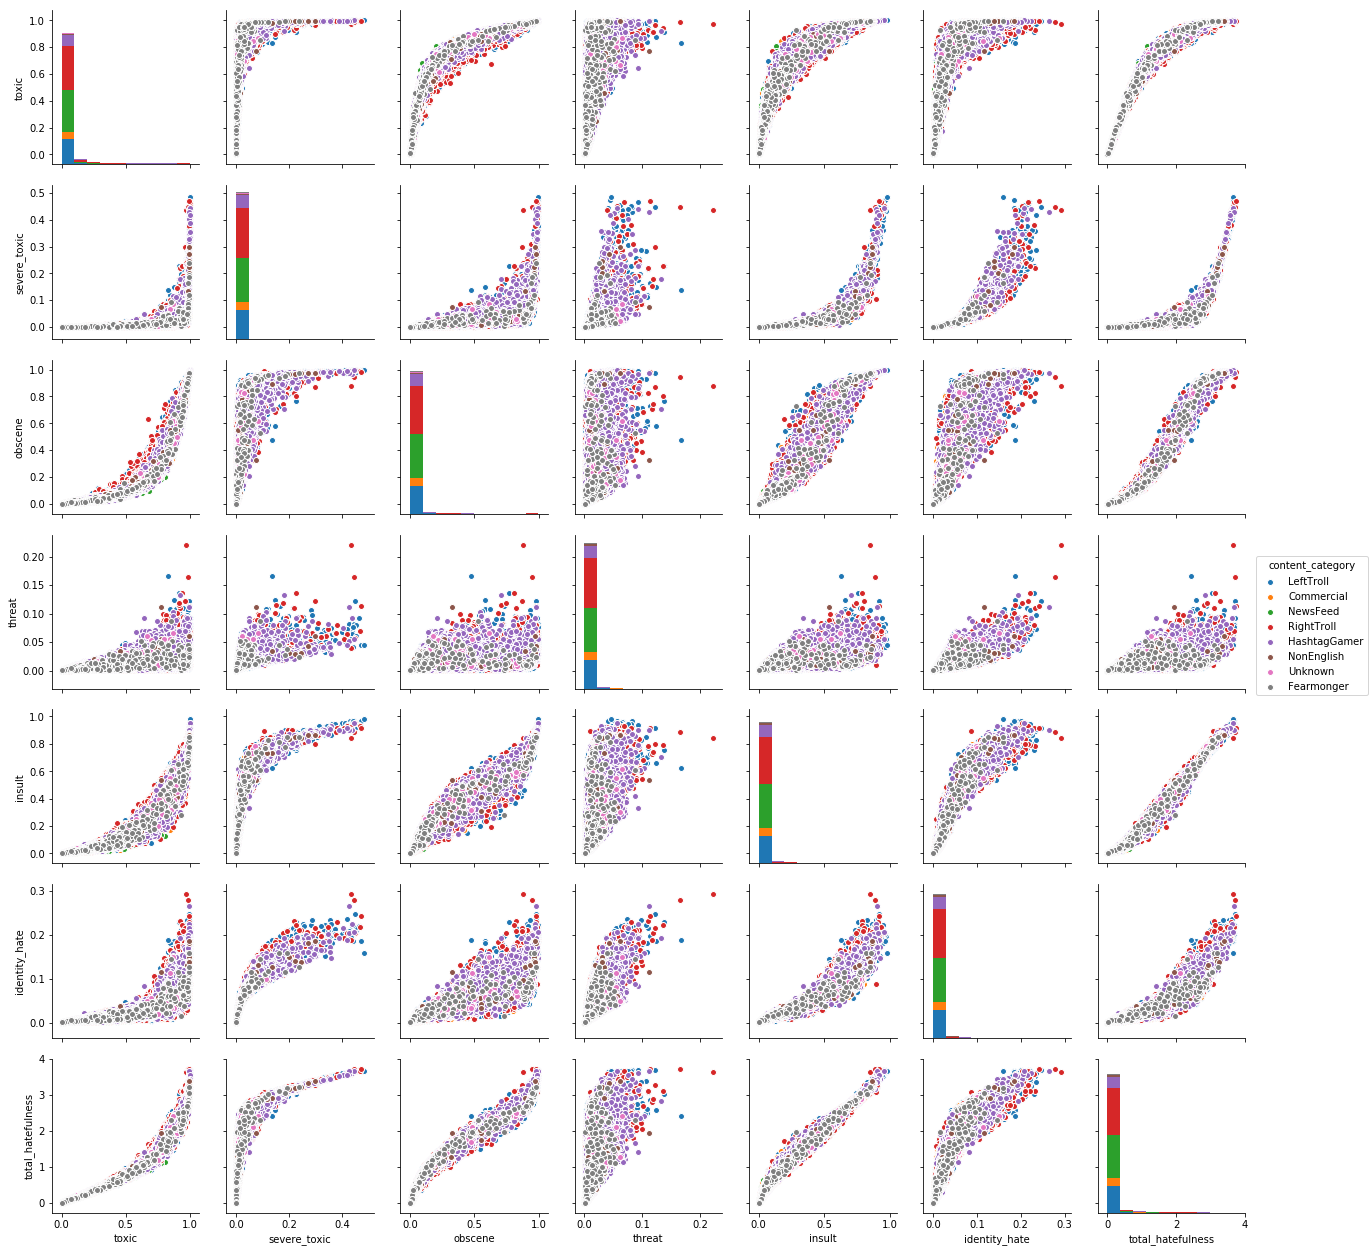

In [18]:
sns.pairplot(toxicity_df, hue = 'content_category')

In [31]:
from IPython.display import Markdown, display
display_markdown = lambda x: display(Markdown(x))
def show_sentence(sent_idx):
    display_markdown('# Input Sentence:\n `{}`'.format(list_tweets[sent_idx]))
    c_pred = model.predict(X_twe[sent_idx:sent_idx+1])[0]
    display_markdown('## Scores')
    for k, p in zip(list_classes, c_pred):
        display_markdown('- {}, Prediction: {:2.2f}%'.format(k, 100*p))
show_sentence(np.random.randint(0,1000))

# Input Sentence:
 `New Hampshire tattoo shop offers free ink for Trump supporters #MakeAmericaGreatAgain https://t.co/V4t4tLXpWW`

## Scores

- toxic, Prediction: 0.05%

- severe_toxic, Prediction: 0.00%

- obscene, Prediction: 0.02%

- threat, Prediction: 0.00%

- insult, Prediction: 0.01%

- identity_hate, Prediction: 0.00%

In [21]:
worst_tweets = np.argsort(-1*toxicity_df['total_hatefulness'].values)
for _, idx in zip(range(5), 
                  worst_tweets):
    show_sentence(idx)

# Input Sentence:
 `im such a fucking jealous asshole i pretend like i dont care but i care so much im gonna explode #IAmOnFire`

## Scores

- toxic, Prediction: 99.61%

- severe_toxic, Prediction: 47.19%

- obscene, Prediction: 98.13%

- threat, Prediction: 11.36%

- insult, Prediction: 91.89%

- identity_hate, Prediction: 24.24%

# Input Sentence:
 `1. Kill the bastard 2. Kill the bastard 3. Kill the bastard 4. Kill the bastard 5. Kill the bastard 6. ... https://t.co/EDJ8NIALqn`

## Scores

- toxic, Prediction: 98.60%

- severe_toxic, Prediction: 44.69%

- obscene, Prediction: 94.46%

- threat, Prediction: 16.47%

- insult, Prediction: 88.92%

- identity_hate, Prediction: 27.84%

# Input Sentence:
 `"Hoe ass nigga, get fucked up like ya folk"  "U got me fuc..." https://t.co/2BCMdL8QqS`

## Scores

- toxic, Prediction: 99.53%

- severe_toxic, Prediction: 44.82%

- obscene, Prediction: 97.61%

- threat, Prediction: 12.18%

- insult, Prediction: 91.81%

- identity_hate, Prediction: 24.68%

# Input Sentence:
 `Shut your bitch ass up I don't suffer fools or fake ass fans @prezidentadams https://t.co/xKwfzvBbLv`

## Scores

- toxic, Prediction: 99.81%

- severe_toxic, Prediction: 46.46%

- obscene, Prediction: 98.85%

- threat, Prediction: 9.21%

- insult, Prediction: 93.99%

- identity_hate, Prediction: 21.97%

# Input Sentence:
 `the sista is basically saying a bumb ass ain't shit bitch ain't fucking you over just cause she ain't shit - da bitch don't know no better 🤣 https://t.co/nmTXVxvDWs`

## Scores

- toxic, Prediction: 99.91%

- severe_toxic, Prediction: 44.64%

- obscene, Prediction: 99.31%

- threat, Prediction: 8.16%

- insult, Prediction: 96.40%

- identity_hate, Prediction: 20.14%

In [22]:
toxicity_df.groupby('content_category').agg(lambda x: round(100*np.mean(x))).reset_index().sort_values('total_hatefulness',
                                                                                                       ascending=False)

,content_category,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_hatefulness
2,HashtagGamer,11.0,0.0,4.0,0.0,4.0,1.0,21.0
1,Fearmonger,9.0,0.0,4.0,0.0,4.0,1.0,18.0
3,LeftTroll,8.0,0.0,3.0,0.0,3.0,1.0,15.0
7,Unknown,7.0,0.0,2.0,0.0,2.0,0.0,12.0
6,RightTroll,6.0,0.0,2.0,0.0,2.0,0.0,10.0
0,Commercial,4.0,0.0,1.0,0.0,1.0,0.0,7.0
5,NonEnglish,3.0,0.0,1.0,0.0,1.0,0.0,5.0
4,NewsFeed,2.0,0.0,0.0,0.0,0.0,0.0,4.0


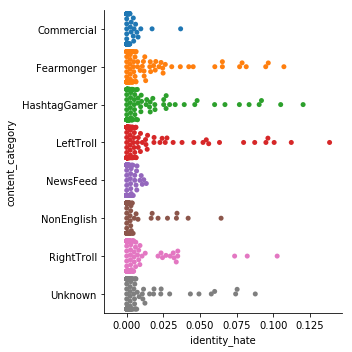

In [23]:
cat_sample_df = toxicity_df.groupby('content_category').apply(lambda x: x.sample(250, replace=False if x.shape[0]>1000 else True)).reset_index(drop=True)
sns.factorplot(y='content_category', x='identity_hate', kind='swarm', data=cat_sample_df, size=5)